In [1]:
import numpy as np
import numpy.typing as npt
from scipy import stats
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [5]:
class conjugate_normal():
    def __init__(self, mu, k, a, b):
        '''
        mu: prior mean
        k: uncertainty about the prior mean (pseudo-samples)
        alpha: shape of variance distribution
        beta: scale of variance distribution

        '''
        self.mu = mu
        self.k = k
        self.alpha = a
        self.beta = b
        self.xlim = np.linspace(self.mu - 3*self.sigma, self.mu + 3*self.sigma, 1001) # For plotting
        self.percentile = .20

    def update(self, x: npt.ArrayLike):
        '''x: data
        '''
        self.mu = self.posterior_mean(x)
        self.alpha = self.posterior_alpha(x)
        self.beta = self.posterior_beta(x)
        assert self.alpha > 1, "alpha must be greater than 1"
        
    def posterior_mean(self, x):
        n = len(x)
        numerator = (self.k * self.mu) + (n * np.mean(x))
        denominator = self.k + n
        return numerator / denominator
    
    def posterior_alpha(self, x):
        n = len(x)
        return self.alpha + (n/2)
    
    def posterior_beta(self, x):
        n = len(x)
        mu_1 = np.mean(x)
        ssd = self.sum_square_diffs(x, mu_1)
        sd = (mu_1 - self.mu)**2
        return self.beta + 0.5*(ssd + (self.k*n*sd)/(self.k+n))

    @property
    def sigma(self):
        return np.sqrt(self.beta / (self.alpha - 1))

    def sum_square_diffs(self, A, B):
        '''Sum of squared differences'''
        squared_differences = (A - B) ** 2
        return np.sum(squared_differences)

    def plot(self, u=3.0, draw_percentile=True, color="blue", **kwargs):
        dist = stats.norm(self.mu, self.sigma)
        plt.plot(self.xlim, dist.pdf(self.xlim), color=color, **kwargs)

        # Add percentile indicator
        if draw_percentile:
            ppf = dist.ppf(self.percentile)
            plt.axvline(
                ppf,
                color=color,
                linestyle="--",
                label=f'{int(self.percentile*100):2d}th Percentile: {ppf:.2f}'
            )

# Define Prior Distribution

The prior distribution expresses our beliefs about the expected mean and variance of a student's scores.

  - **mu** (float): the prior mean
  - **k** (int): the weight of our prior distribution as a pseudo-sample size. If `k=5`, then our prior has the same weight as 5 observations.
  - **alpha** (float): the shape of the gamma distribution representing our expectations of the student's score variance.
  - **beta**(float): the scale of the gamma distribution representing our expectations of the student's score variance.

Beta and alpha are parameters of the gamma distribution. Together, they represent our expectation about the variance and our level of confidence in that expectation. The expected variance is equal to `beta/(alpha-1)`. Since we expect a standard deviation/variance of 1.0*, `alpha = beta + 1`. Some options are:

`alpha=5, beta=4` - Strong confidence  
`alpha=3, beta=2` - Moderate confidence  
`alpha=2.1, beta=1.1` - Weak confidence  

*Since variance is standard deviation squared, standard deviation and variance are equal when they are 1.0.

In [6]:
mu_0 = 1.0
k = 5
alpha_0 = 3
beta_0 = 2

## Build model

You can rerun the below cell to see how random samples would influence behavior.

Mu: 1.20, Sigma: 0.87


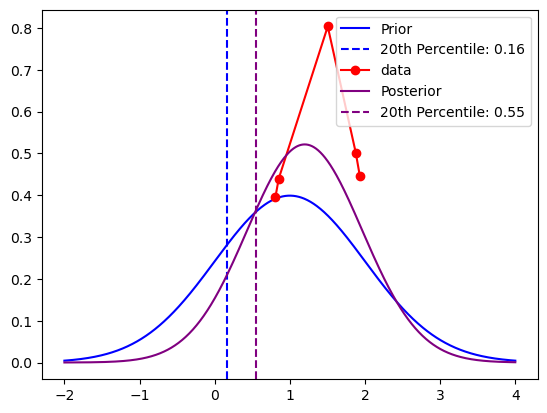

In [7]:
model = conjugate_normal(mu_0, k, alpha_0, beta_0)

# Plot prior
model.plot(color="blue", label="Prior")

# Simulate data
student_mean = 2.0 # this is the (unobservable) population mean for a single student's summary scores
student_std = .5 # this is the (unobservable) population standard deviation for a single student's summary scores
observations = 5 # how many scores to simulate
data = rng.normal(loc=student_mean, scale=student_std, size=observations)

# Plot simulated data
def plot_data(data):
    data.sort()
    fit = stats.norm.pdf(data, np.mean(data), np.std(data))
    plt.plot(data, fit, '-o', color="red", label="data")
plot_data(data)

# Update model with simulated data
model.update(data)

# Plot posterior
model.plot(color="purple", label="Posterior")
print(f"Mu: {model.mu:.2f}, Sigma: {np.sqrt(model.sigma):.2f}")
plt.legend();

### A note on variation within volumes/pages

In the above example, the prior hyperparameters (mean, pseudo-sample size, alpha, and beta) are specified by the researcher.

However, it would be possible to instead specify a hyperprior (using the same hyperparameters) for all volumes. 

Before estimating an individual student's score distribution, we would estimate the score distribution for an entire page or volume by updating our hyperprior with all the scores for that page/volume.

This updated distribution would then be used as the prior to estimate the student's score distribution.

...hierarchical!

In [8]:
mu_global = 1.0
k_global = 15
alpha_global = 2
beta_global = 1

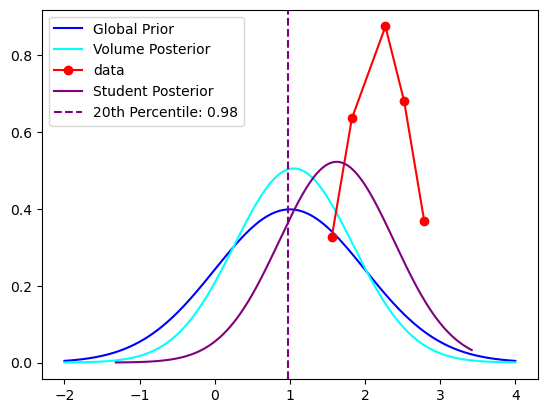

In [10]:
volume = conjugate_normal(mu_global, k_global, alpha_global, beta_global)

volume.plot(draw_percentile=False, color="blue", label="Global Prior")

# Simulate volume data
volume_mean = 1.5
volume_std = 1.0
volume_observations = 25
volume_data = rng.normal(loc=volume_mean, scale=volume_std, size=volume_observations)

volume.update(volume_data)
volume.plot(draw_percentile=False, color="cyan", label="Volume Posterior")

# Simulate student data
student_mean = 2.5
student_std = .5
student_observations = 5
student_data = rng.normal(loc=student_mean, scale=student_std, size=student_observations)

plot_data(student_data)

# Giving the volume prior a weight equal to the number of student scores
k_volume = student_observations
student = conjugate_normal(volume.mu, k_volume, volume.alpha, volume.beta)
student.update(student_data)

# Plot posterior
student.plot(color="purple", label="Student Posterior")

plt.legend();